In [1]:
from datacube import Datacube
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from scipy import stats, signal
from datacube.utils.geometry import assign_crs

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices
# from dea_tools.temporal_statistics import fast_completion, smooth

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:39205 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


## Load Data

In [3]:
lat, lon = -30.6378, 148.7110
buffer = 0.01
time = ('2014', '2020')

In [4]:
dc = Datacube(app='whatevrr')

query = {'lon': (lon - buffer, lon + buffer),
         'lat': (lat - buffer, lat + buffer),
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "average"}}

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [5]:
display_map((lon - buffer, lon + buffer),(lat - buffer, lat + buffer))

In [6]:
ds = load_ard(dc=dc, 
              dask_chunks={'x':-1, 'y':-1, 'time':-1},
              products=["ga_ls7e_ard_3", "ga_ls8c_ard_3"], # s2a_ard_granule, s2b_ard_granule
              **query)
print(ds)

Finding datasets
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 597 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 597, x: 73, y: 83)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-05T23:57:54.147384 ... 2020-12...
  * y            (y) float64 -3.437e+06 -3.437e+06 ... -3.44e+06 -3.44e+06
  * x            (x) float64 1.579e+06 1.579e+06 ... 1.582e+06 1.582e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(597, 83, 73), meta=np.ndarray>
    nbart_nir    (time, y, x) float32 dask.array<chunksize=(597, 83, 73), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


## Calculate standardized vegetation anomalies

Alternative approach: take a 12-month rolling average, then detrend the data. Signal detrend requires removing all NaNs.

    data = data.rolling(time=52, center=True).mean()[26:-26,...]\
    mean = data.mean(axis=0)
    data = xr.DataArray(signal.detrend(data, axis=0), dims=data.dims, coords=data.coords) + mean


### Firstly, calculate NDVI and fill the gaps

In [7]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='ga_ls_3')

#interpolate NDVI to a monthly frequency
ndvi = ndvi.interpolate_na(dim='time', method='linear',).resample(time="1W").interpolate("linear")
ndvi = ndvi.NDVI

Dropping bands ['nbart_red', 'nbart_nir']


### Calculate the vegetation climatologies

In [8]:
climatology_mean = ndvi.groupby("time.month").mean("time")
climatology_std = ndvi.groupby("time.month").std("time")


### Calculate standardised anomalies 

In [9]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ndvi.groupby("time.month"),
    climatology_mean,
    climatology_std,
    output_dtypes=[ndvi.dtype],
    dask="allowed"
)

stand_anomalies = stand_anomalies.compute()
print(stand_anomalies)

<xarray.DataArray 'NDVI' (time: 365, y: 83, x: 73)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.32423187, -0.39743353, -0.49245679, ..., -0.55166453,
         -0.48007521, -0.35298194],
        [-0.43835854, -0.67709601, -0.73404741, ..., -0.39111858,
         -0.53047442, -0.43569987],
        [-0.56044058, -0.61493481, -0.63192591, ..., -0.36721178,
         -0.55837815, -0.73527696],
...
        [ 0

### Plot the standardised vegetation anomalies

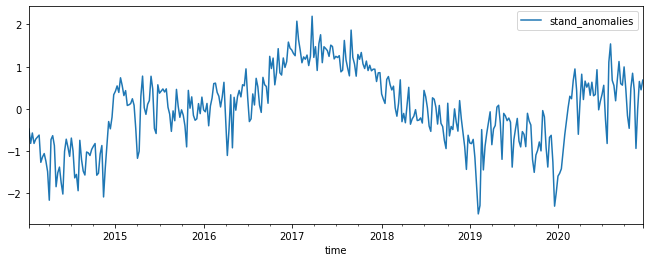

In [10]:
#convert to a 1d timeseries by taking the zonal mean
zonal_mean = stand_anomalies.mean(['x','y'])

#convert to a pandas dataframe
df = zonal_mean.drop('spatial_ref').drop('month').to_dataframe(name='stand_anomalies').dropna()

df.plot(figsize=(11,4));

## Testing autocorrelation


#### Check for Autocorrelation (ie correlation between adjacent timesteps)

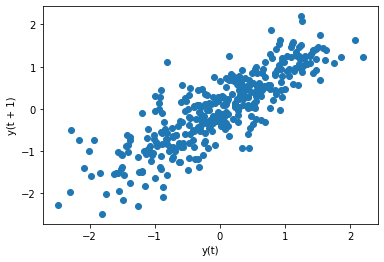

In [11]:
lag_plot(df)

#### Pearsons coefficient

In [12]:
values = pd.DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.843465
t+1  0.843465  1.000000


## Check for stationarity

If the p-value on the ADF stat is <0.05, then time-series is stationary

The KPSS statistic checks for trend stationarity. If the p-value on the KPSS stat is > 0.05, the time-series has a trend

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df.values, autolag='AIC')
print(f'ADF Statistic: {round(result[0],3)}')
print(f'p-value: {round(result[1],3)}')

# KPSS Test
result = kpss(df.values, regression='c')
print('\nKPSS Statistic: %f' % round(result[0],3))
print('p-value: %f' % round(result[1],3))


ADF Statistic: -2.534
p-value: 0.107

KPSS Statistic: 0.314000
p-value: 0.100000


/env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


## Check 'forecast-ability' 

Using the 'Sample Entropy' we can determine how susceptible our time-series is to forecasting.  A low entropy means means more forecastable.  Compare the time-series' entropy to that of the random array for comparison.

In [14]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

#create a random array for comparison
random_arr = np.random.randint(100, size=200)

print("time-series entropy is: " , SampEn(df.values, m=2, r=0.2*np.std(df.values))) 
print('random array entropy: ', SampEn(random_arr, m=2, r=0.2*np.std(random_arr)))

time-series entropy is:  1.400298409203907
random array entropy:  2.285040783343136


## Forecasting using autoregression

In [43]:
test_length = 4
lag = 50

In [44]:
# create and evaluate an updated autoregressive model
# split dataset
X = df.values
train, test = X[1:len(X)-test_length], X[len(X)-test_length:]

# train autoregression
window = 25
model = AutoReg(train, lags=lag)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]

predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


predicted=-0.402242, expected=-0.001840
predicted=0.319257, expected=0.650701
predicted=0.412734, expected=0.452307
predicted=0.293831, expected=0.681203


/env/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Test RMSE: 0.325


(-1.5, 1.5)

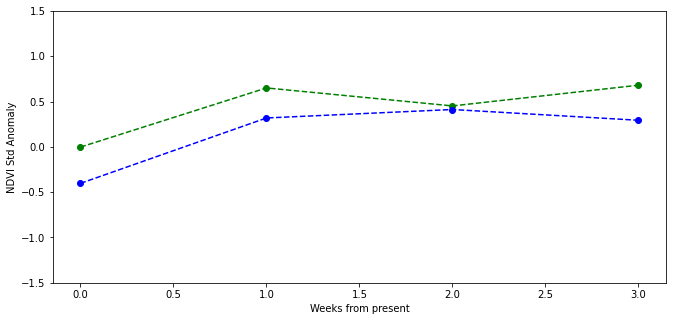

In [45]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
fig=plt.figure(figsize=(11,5))
# ax = df.plot(figsize=(11,5))
plt.plot(test, color='green', linestyle='dashed', marker='o')
plt.plot(predictions,color='blue', linestyle='dashed', marker='o')
plt.xlabel('Weeks from present')
plt.ylabel('NDVI Std Anomaly')
plt.ylim(-1.5,1.5)

---

# Attempt forecast on 3D Array

Vectorized ufunc works but can be very slow. xr.map_blocks could be a better solution



In [ ]:
%%time
def xr_autoregress(da, test_length, window, lags):
    #dropna conveneiently with pandas
    da =  da[~np.isnan(da)]
    # split dataset
    train, test = da[1:len(da)-test_length], da[len(da)-test_length:]
    # train autoregression
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]

    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs) 
    
    return np.array(predictions).flatten()

predict = xr.apply_ufunc(xr_autoregress,
                      stand_anomalies.isel(time=range(0, 73)), #.chunk({'x':100,'y':100, 'time':-1}),#.isel(x=range(0,100),y=range(0,100)),
                      kwargs={'test_length':2,'window':25,'lags':25},
                      input_core_dims=[['time']],
                      output_core_dims=[['predictions']], 
                      output_sizes=({'predictions':2}),
                      exclude_dims=set(('time',)),
                      vectorize=True,
                      dask="allowed",
                      output_dtypes=[stand_anomalies.dtype]).compute()

print(predict)

In [ ]:
predict.plot(col='predictions', col_wrap=2, cmap='BrBG', vmin=-2.0, vmax=2.0, figsize=(12,6))

In [ ]:
stand_anomalies.isel(time=range(-3,-1)).plot(col='time', col_wrap=2, cmap='BrBG', vmin=-2.0, vmax=2.0, figsize=(12,6));

### Try with Numba to speed up

This works 'lazily' but then fails when trying to compute: 'killed worker'


In [ ]:
import dask
import distributed
dask.config.set({'distributed.scheduler.allowed-failures': 50}) 

In [ ]:
%%time
from numba import float64, guvectorize
from statsmodels.tsa.ar_model import AutoReg

@guvectorize("(float64[:], float64[:])", "(n) -> (n)", forceobj=True)
def xr_autoregress_gufunc(da, out):
    test_length=2
    lags=25
    window=25
    #dropnas
    print(da)
    da =  da[~np.isnan(da)]
    # split dataset
    train, test = da[1:len(da)-test_length], da[len(da)-test_length:]
    # train autoregression
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]

    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs) 
    
    out[:] =  np.array(predictions).flatten()
    
predict = xr.apply_ufunc(xr_autoregress_gufunc,
                      stand_anomalies.chunk({'time':-1}),
                      input_core_dims=[['time']],
                      output_core_dims=[['predictions']], 
                      output_sizes=({'predictions':2}),
                      exclude_dims=set(('time',)),
                      dask="parallelized",
                      output_dtypes=[stand_anomalies.dtype])

predict

In [ ]:
predict = predict.compute()

In [ ]:
# stand_anomalies = stand_anomalies.drop('spatial_ref')
# template = stand_anomalies.transpose("y", "x", "time").chunk({'time':-1})
# stand_anomalies = stand_anomalies.chunk({'time':-1}).map_blocks(
#                             smooth,
#                             template=template
#                         )

In [ ]:
# quarter= {'JFM': [1,2,3],
#            'FMA': [2,3,4],
#            'MAM': [3,4,5],
#            'AMJ': [4,5,6],
#            'MJJ': [5,6,7],
#            'JJA': [6,7,8],
#            'JAS': [7,8,9],
#            'ASO': [8,9,10],
#            'SON': [9,10,11],
#            'OND': [10,11,12],
#            'NDJ': [11,12,1],
#            'DJF': [12,1,2],
#                       }

# def ndvi_climatology(ndvi, stat='mean'):
    
#     ndvi_var = []
#     for q in quarter:
        
#         ix=ndvi['time.month'].isin(quarter[q])
        
#         if stat=='std':
#             ndvi_clim=ndvi.where(ix, drop = True).std(dim='time')   
#         if stat=='mean':
#             ndvi_clim=ndvi.where(ix, drop = True).mean(dim='time') 
        
#         ndvi_clim=ndvi_clim.to_array(name=q).drop('variable').squeeze()
#         ndvi_var.append(ndvi_clim)

#     q_clim = xr.merge(ndvi_var)   
    
#     #assign back attributes
#     crs = ndvi.geobox.crs
#     q_clim = assign_crs(q_clim, str(crs))

#     return q_clim

# mean = ndvi_climatology(ndvi,stat='mean').compute()
# std = ndvi_climatology(ndvi,stat='std').compute()